In [24]:
##############################################################################
# Description: Baysian Neural Network using Numpyro
# Author: Tobias Leitgeb
##############################################################################

import numpyro
numpyro.set_platform("cpu")
from numpyro.infer import MCMC, NUTS, SVI, Trace_ELBO, Predictive
import numpyro.distributions as dist
import jax
import jax.numpy as jnp
import jax.random as jr
from typing import Tuple, Callable, List
import matplotlib.pyplot as plt

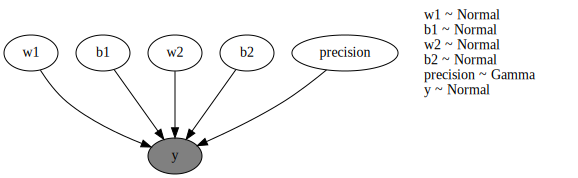

In [33]:
def bnn_model(
        X: jax.Array,
        y: jax.Array,
        layer_sizes: List[int],
):
    """
    Bayesian neural network model with a single hidden layer. The input X is a
    matrix of shape (n, d) with n data points and d features. The output y is
    a matrix of shape (n, 2) with n data points and 2 outputs corresponding to
    two different functions, which are predicted simultaniously.
    """
    n, d = X.shape

    #assert y.shape == (n, 2)

    # Priors
    w1 = numpyro.sample("w1", dist.Normal(jnp.zeros((d, layer_sizes[0])), 1))
    b1 = numpyro.sample("b1", dist.Normal(jnp.zeros(layer_sizes[0]), 1))
    w2 = numpyro.sample("w2", dist.Normal(jnp.zeros((layer_sizes[0], 2)), 1))
    b2 = numpyro.sample("b2", dist.Normal(jnp.zeros(2), 1))
    precision = numpyro.sample("precision", dist.Gamma(1, 1))
    # Forward pass
    z1 = jnp.dot(X, w1) + b1
    a1 = jax.nn.relu(z1)
    z2 = jnp.dot(a1, w2) + b2
    z2 = z2.squeeze()

    

    # Likelihood
    numpyro.sample("y", dist.Normal(z2, 1/jnp.sqrt(precision)), obs=y)

try:
    render = numpyro.render_model(bnn_model, (jnp.zeros((10, 2)), jnp.zeros((10, 2)), [10]), render_distributions=True)
    
except:
    render = None
    print("Module not installed. (pip install graphviz), (sudo apt-get install graphviz)")
    
render

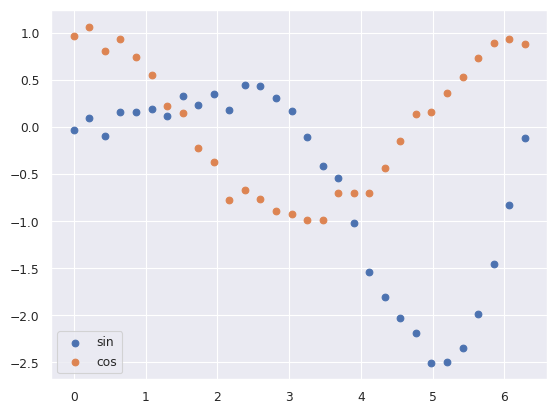

In [32]:
key = jr.PRNGKey(0)
def generate_sin_cos_data_with_noise(n_points, noise_level=0.1, key=key):
    """
    Generates a dataset of n_points with the first dimension as a sine curve
    and the second dimension as a cosine curve, both with added Gaussian noise,
    and returns separate X and Y vectors.

    Args:
        n_points (int): Number of points to generate.
        noise_level (float): Standard deviation of Gaussian noise to add.

    Returns:
        tuple: Two np.ndarrays, X and Y. X is a vector of shape (n_points, 1) representing
               the input values, and Y is an array of shape (n_points, 2) with noisy sine
               values in the first column and noisy cosine values in the second column.
    """
    x = jnp.linspace(0, 2 * jnp.pi, n_points).reshape(-1, 1)
    sin_curve = jnp.sin(x)*x**2/10 + jr.normal(key, (n_points, 1)) * noise_level
    cos_curve = jnp.cos(x) + jr.normal(key, (n_points, 1)) * noise_level
    y = jnp.hstack((sin_curve, cos_curve))
    return x, y

X_train, Y_train = generate_sin_cos_data_with_noise(30)
plt.scatter(X_train, Y_train[:, 0], label='sin')
plt.scatter(X_train, Y_train[:, 1], label='cos')
plt.legend()


In [7]:
# Inference using Markov Chain Monte Carlo
kernel = NUTS(bnn_model)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000)
mcmc.run(jax.random.PRNGKey(0), X_train, Y_train, [10])
mcmc.print_summary()

sample: 100%|██████████| 3000/3000 [00:13<00:00, 229.62it/s, 1023 steps of size 2.57e-03. acc. prob=0.89]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      b1[0]     -0.36      1.33     -0.29     -2.27      1.98    186.23      1.00
      b1[1]     -0.85      1.65     -0.59     -4.01      1.55     55.96      1.03
      b1[2]     -0.90      1.65     -0.58     -4.04      1.42     41.52      1.05
      b1[3]     -0.31      1.28     -0.21     -2.55      1.53    135.11      1.00
      b1[4]     -1.31      1.93     -1.03     -4.53      1.37     20.91      1.01
      b1[5]     -0.70      1.55     -0.49     -3.57      1.75     44.17      1.04
      b1[6]     -0.42      1.30     -0.37     -2.54      1.69    133.37      1.00
      b1[7]     -0.90      1.61     -0.63     -3.94      1.53     62.78      1.02
      b1[8]     -0.63      1.47     -0.48     -2.88      2.05     66.93      1.01
      b1[9]     -0.59      1.50     -0.38     -3.14      1.97     62.73      1.02
      b2[0]      0.13      0.75      0.15     -1.11      1.32    551.30      1.00
      b2[1]    

In [8]:
#predict the test data
X_test, Y_test = generate_sin_cos_data_with_noise(100)
mcmc_samples = mcmc.get_samples()
w1 = mcmc_samples['w1']
b1 = mcmc_samples['b1']
w2 = mcmc_samples['w2']
b2 = mcmc_samples['b2']
precision = mcmc_samples['precision']

# Predictions with forward pass
predictions = []
for i in range(100):
    z1 = jnp.dot(X_test, w1[i]) + b1[i]
    a1 = jax.nn.relu(z1)
    z2 = jnp.dot(a1, w2[i]) + b2[i]
    z2 = z2.squeeze()
    predictions.append(z2)
predictions = jnp.array(predictions)


# Predictive distribution
predictive = Predictive(bnn_model, mcmc.get_samples(), return_sites=["y"])
predictions2 = predictive(jax.random.PRNGKey(1), X_test, None, [10])
predictions2 = predictions2['y'] 

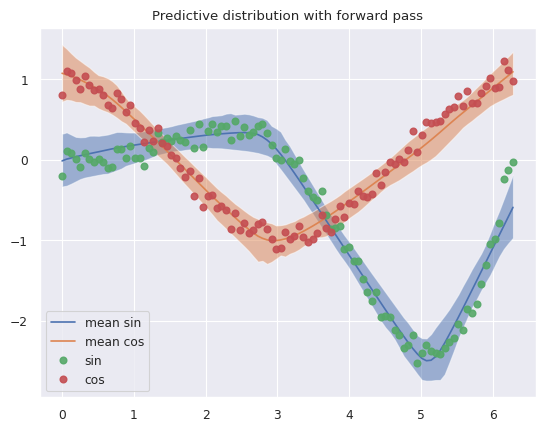

In [19]:
import seaborn as sns
sns.set_theme("paper")
plt.title("Predictive distribution with forward pass")
plt.plot(X_test, jnp.mean(predictions, axis=0)[:, 0], label='mean sin')
plt.plot(X_test, jnp.mean(predictions, axis=0)[:, 1], label='mean cos')
plt.fill_between(
    X_test.flatten(), 
    jnp.percentile(predictions, 2.5, axis=0)[:, 0], 
    jnp.percentile(predictions, 97.5, axis=0)[:, 0], 
    alpha=0.5
)
plt.fill_between(
    X_test.flatten(), 
    jnp.percentile(predictions, 2.5, axis=0)[:, 1], 
    jnp.percentile(predictions, 97.5, axis=0)[:, 1], 
    alpha=0.5
)
plt.plot(X_test, Y_test[:, 0], 'o', label='sin',alpha = 0.9)
plt.plot(X_test, Y_test[:, 1], 'o', label='cos',alpha = 0.9)
plt.legend()

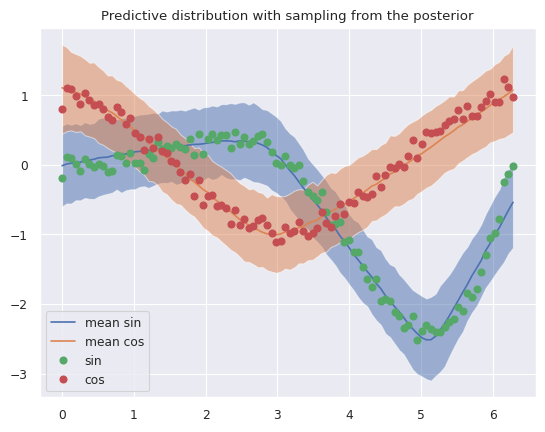

In [20]:
plt.title("Predictive distribution with sampling from the posterior")
plt.plot(X_test, jnp.mean(predictions2, axis=0)[:, 0], label='mean sin')
plt.plot(X_test, jnp.mean(predictions2, axis=0)[:, 1], label='mean cos')
plt.fill_between(X_test.flatten(), jnp.percentile(predictions2, 2.5, axis=0)[:, 0], jnp.percentile(predictions2, 97.5, axis=0)[:, 0], alpha=0.5)
plt.fill_between(X_test.flatten(), jnp.percentile(predictions2, 2.5, axis=0)[:, 1], jnp.percentile(predictions2, 97.5, axis=0)[:, 1], alpha=0.5)
plt.plot(X_test, Y_test[:, 0], 'o', label='sin')
plt.plot(X_test, Y_test[:, 1], 'o', label='cos')
plt.legend()

In [ ]:
#inference with svi
from numpyro.infer.autoguide import AutoDiagonalNormal, AutoLaplaceApproximation, AutoMultivariateNormal, AutoIAFNormal, AutoLowRankMultivariateNormal, AutoDelta
guide = AutoDelta(bnn_model)
svi = SVI(bnn_model, guide, numpyro.optim.Adam(0.01), Trace_ELBO())
svi_result = svi.run(jax.random.PRNGKey(0), 50000, X_train, Y_train, [30])


X_test = jnp.linspace(0, 2 * jnp.pi, 100).reshape(-1, 1)
samples = guide.sample_posterior(jax.random.PRNGKey(1), svi_result.params, sample_shape=(1000,))

predictive = Predictive(bnn_model, samples, return_sites=["y"])
predictions2 = predictive(jax.random.PRNGKey(1), X_test, None, [10])
predictions2 = predictions2['y'] 

100%|██████████| 50000/50000 [00:03<00:00, 15909.27it/s, init loss: 234.5349, avg. loss [47501-50000]: 130.0668]


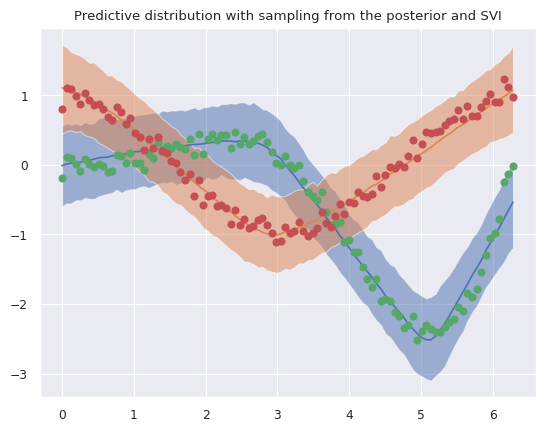

In [23]:
plt.title("Predictive distribution with sampling from the posterior and SVI")
plt.plot(X_test, jnp.mean(predictions2, axis=0)[:, 0], label='mean sin')
plt.plot(X_test, jnp.mean(predictions2, axis=0)[:, 1], label='mean cos')
plt.fill_between(X_test.flatten(), jnp.percentile(predictions2, 2.5, axis=0)[:, 0], jnp.percentile(predictions2, 97.5, axis=0)[:, 0], alpha=0.5)
plt.fill_between(X_test.flatten(), jnp.percentile(predictions2, 2.5, axis=0)[:, 1], jnp.percentile(predictions2, 97.5, axis=0)[:, 1], alpha=0.5)
plt.plot(X_test, Y_test[:, 0], 'o', label='sin')
plt.plot(X_test, Y_test[:, 1], 'o', label='cos')